# 第三章第四节 数据增强——transforms&albumentations


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt

In [9]:
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
# 获取本文件所在目录的上上级目录，也就是项目根目录
os.path.dirname(os.path.dirname(os.getcwd()))
# sys.path

'd:\\ai\\pytorch\\l-PyTorch-Tutorial-2nd'

In [ ]:

def transform_invert(img_, transform_train):
    """
    将data 进行反transfrom操作
    :param img_: tensor
    :param transform_train: torchvision.transforms
    :return: PIL image
    """
    # 反归一化操作
    if 'Normalize' in str(transform_train):
        # 检查 transform_train 是否包含 transforms.Normalize 归一化。
        norm_transform = list(filter(lambda x: isinstance(
            x, transforms.Normalize), transform_train.transforms))
        # 获取 Normalize(mean, std) 中的 mean 和 std。
        mean = torch.tensor(
            norm_transform[0].mean, dtype=img_.dtype, device=img_.device)
        std = torch.tensor(
            norm_transform[0].std, dtype=img_.dtype, device=img_.device)
        # 这里 .mul_() 和 .add_() 是 in-place 操作（直接修改 img_ 变量）。这里的 mean 和 std 是标量，需要转换为矩阵。
        img_.mul_(std[:, None, None]).add_(mean[:, None, None])
# 输入 img_ 形状：[C, H, W]（torch.Tensor）。
# 转换为 H*W*C（符合 PIL.Image 格式）。
    img_ = img_.transpose(0, 2).transpose(0, 1)  # C*H*W --> H*W*C
    if 'ToTensor' in str(transform_train) or img_.max() < 1:
        # img_.detach() 的作用是分离（detach）img_ 的计算图，使其成为一个不需要梯度的张量，从而避免梯度计算的开销。
        # 直接调用 .numpy() 需要 Tensor 处于 requires_grad=False 状态，否则会报错
        img_ = img_.detach().numpy() * 255
# RGB 彩色图像（3 通道）：转换为 PIL.Image，并 convert('RGB')。
# 灰度图像（1 通道）：squeeze() 去掉通道维度，再转换为 PIL.Image。
# 其他情况报错。
    if img_.shape[2] == 3:
        img_ = Image.fromarray(img_.astype('uint8')).convert('RGB')
    elif img_.shape[2] == 1:
        img_ = Image.fromarray(img_.astype('uint8').squeeze())
    else:
        raise Exception(
            "Invalid img shape, expected 1 or 3 in axis 2, but got {}!".format(img_.shape[2]))

    return img_

In [12]:
class COVID19Dataset(Dataset):
    def __init__(self, root_dir, txt_path, transform=None):
        """
        获取数据集的路径、预处理的方法
        """
        self.root_dir = root_dir
        self.txt_path = txt_path
        self.transform = transform
        self.img_info = []  # [(path, label), ... , ]
        self.label_array = None
        self._get_img_info()

    def __getitem__(self, index):
        """
        输入标量index, 从硬盘中读取数据，并预处理，to Tensor
        :param index:
        :return:
        """
        path_img, label = self.img_info[index]
        img = Image.open(path_img).convert('L')
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        if len(self.img_info) == 0:
            raise ValueError(
                "ndata_dir:{} is a empty dir! Please checkout your path to images!".format(self.root_dir))
        return len(self.img_info)

    def _get_img_info(self):
        """
        实现数据集的读取，将硬盘中的数据路径，标签读取进来，存在一个list中
        path, label
        :return:
        """
        # 读取txt，解析txt
        with open(self.txt_path, "r") as f:
            txt_data = f.read().strip()
            txt_data = txt_data.split("\n")
        self.img_info = [(os.path.join(self.root_dir, i.split()[0]), int(i.split()[2]))
                         for i in txt_data]


# you can download the datasets from
# https://pan.baidu.com/s/18BsxploWR3pbybFtNsw5fA  code：pyto
# path to datasets——covid-19-demo
# 构造绝对路径
abs_path = os.path.dirname(os.path.dirname(os.getcwd()))
root_dir = abs_path+r"\data\datasets\covid-19-demo"
img_dir = os.path.join(root_dir, "imgs")
path_txt_train = os.path.join(root_dir, "labels", "train.txt")

### Resize


In [13]:
transforms_func = transforms.Compose([
    transforms.Resize((2, 2)),
    transforms.ToTensor()
])
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape, data)

torch.Size([2, 1, 2, 2]) tensor([[[[0.4510, 0.4314],
          [0.5373, 0.5294]]],


        [[[0.3804, 0.3882],
          [0.4941, 0.5294]]]])


思考为什么会报错？
提示：

1. 注意 resize 的 size 为 int 时的操作
2. 注意看报错信息，torch.stack....
3. 通常会 resize 会配 CenterCrop 进行使用，以此保证图像大小一致


In [ ]:
transforms_func = transforms.Compose([
    transforms.Resize(5),
    transforms.ToTensor()
])
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape, data)
# 在批量处理数据时，遇到了大小不一致的图片：
# 第 0 个样本: [1, 6, 5]（高 6）
# 第 1 个样本: [1, 5, 5]（高 5）

RuntimeError: stack expects each tensor to be equal size, but got [1, 6, 5] at entry 0 and [1, 5, 5] at entry 1

### Normalize


In [15]:
transforms_func = transforms.Compose([
    transforms.Resize((2, 2)),
    transforms.ToTensor(),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape, data)

torch.Size([2, 1, 2, 2]) tensor([[[[ 0.2549,  0.1569],
          [ 0.6863,  0.6471]]],


        [[[-0.0980, -0.0588],
          [ 0.4706,  0.6471]]]])


### FiveCrop


观察一下代码错误，可自行复制代码段到 pycharm 中单步调试，观察何处报错。
提示：由于 compose 是依次运行的，由于 fivecrop 返回的 img 不能被下一个 transforms 方法接收，因此报错。
代码段回顾：
def **call**(self, img):
for t in self.transforms:
img = t(img)
return img


In [18]:
transforms_func = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.FiveCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape, data)

TypeError: pic should be PIL Image or ndarray. Got <class 'tuple'>

FiveCrop 的正确打开方式
代码解释：

1. transforms.Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops]))
   Lambda 是可自定义的变换操作，在这里为的是将一个 list 的图像堆叠为符合后续变换需要的 3D-tensor 形式。到了 compose 里，传入 lambda 的是 fivecrop 的输出，是一个长度为 5 的 list，然后再 lambda 里，对这个 list 进行循环，每一个图像会经过 totensor，然后这个 list 经过 torch.stack，就变为了一个 4D-tensor。（这里需要大家熟悉 compoese 的 call 函数里的那个 for 循环，各变换是依次进行的。）

2. print(data.shape, data)
   dataloader 将 4D-tensor 进行组装，增加 batch 的维度，得到了一个[2, 5, 1, 224, 224]的张量

3. result = model(data.view(-1, c, h, w))
   因为模型的输入只能是 4D-tensor，shape 为 BCHW，所以需要把数据重新排一下，把 crops 暂时排到 batch 维度


In [21]:
class TinnyCNN(nn.Module):
    def __init__(self, cls_num=2):
        super(TinnyCNN, self).__init__()
        self.convolution_layer = nn.Conv2d(1, 1, kernel_size=(3, 3))
        self.fc = nn.Linear(36, cls_num)

    def forward(self, x):
        x = self.convolution_layer(x)
        x = x.view(x.size(0), -1)
        # view() 是 PyTorch 中用来调整张量形状的方法。这里将卷积层的输出展平成一个向量。
# x.size(0) 保持批次大小不变，-1 会自动推算展平后的维度。
# 展平后的形状为 [batch_size, 36]（假设卷积后的输出为大小 36）。
        out = self.fc(x)
        return out


model = TinnyCNN(2)

In [ ]:
from torchvision.transforms import ToTensor
transforms_func = transforms.Compose([
    transforms.Resize((10, 10)),
    # 将图像裁剪成4个角落和1个中心裁剪，裁剪后的每个部分大小为8x8像素。
    transforms.FiveCrop(8),
    transforms.Lambda(lambda crops: torch.stack(
        [ToTensor()(crop) for crop in crops])),
    # 对数据进行归一化处理，标准化图像的像素值，使其均值为0.4，标准差为0.2
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape)
    # 模型推理
    # data的形状为 (batch_size, number_of_crops, channels, height, width)，其中 batch_size 是批量大小，number_of_crops 是裁剪的数量（此处为5），channels 是图像通道数（灰度图像为1），height 和 width 是图像的尺寸。
    bs, ncrops, c, h, w = data.size()
    # 将裁剪的图像展平成一个批量后，传入模型进行推理。-1 用于将批量大小和裁剪数合并。
    result = model(data.view(-1, c, h, w))  # fuse batch size and ncrops
    print(result.shape, result)
    # 平均5个结果，当然根据任务，可以选取最大值、取最小值等操作。
    # ：将模型的输出按批次和裁剪数重塑，使用 .mean(1) 来计算每个样本在所有裁剪结果上的平均值，从而得到最终的预测结果。
    result_avg = result.view(bs, ncrops, -1).mean(1)
    print(result_avg.shape, result_avg)
    ###

torch.Size([2, 5, 1, 8, 8])
torch.Size([10, 2]) tensor([[ 0.4385,  0.1014],
        [ 0.1878, -0.1410],
        [ 0.6890, -0.1181],
        [ 0.2224, -0.4320],
        [ 0.5679, -0.5295],
        [ 0.2980,  0.0096],
        [ 0.1435,  0.4287],
        [ 1.0002,  0.0610],
        [ 0.3529, -0.1042],
        [ 0.7207, -0.2163]], grad_fn=<AddmmBackward0>)
torch.Size([2, 2]) tensor([[ 0.4211, -0.2238],
        [ 0.5030,  0.0358]], grad_fn=<MeanBackward1>)


FiveCrop 的使用就到这里，TenCrop 不再演示，使用方法完全一致，主要要求大家深刻理解 transforms.Compose 是如何工作的，理解 transforms 方法前后的配套关系。


### 其余 API 学习示范


授人以渔：其余的二十多个不在一一介绍，只需要到官方文档上查看接口，并利用本代码运行，观察效果即可。


torch.Size([2, 1, 224, 224])
(224, 224)


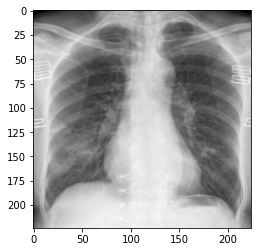

In [ ]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape)
    # data[0, -1]：表示选择第一个样本的最后一个通道（例如 RGB 图像中的蓝色通道）。
# data[0, ...]：表示选择第一个样本的所有通道。
    img_tensor = data[0, ...]     # C H W
    img = transform_invert(img_tensor, transforms_func)
    print(img.size)
    plt.imshow(img, cmap="gray")
    plt.show()

#### RandomVerticalFlip

RandomVerticalFlip 是 PyTorch 中 torchvision.transforms 提供的一个图像增强方法，用于以一定概率对图像进行垂直翻转。它常用于数据预处理和数据增强中，以增强模型的泛化能力


torch.Size([2, 1, 224, 224])
(224, 224)


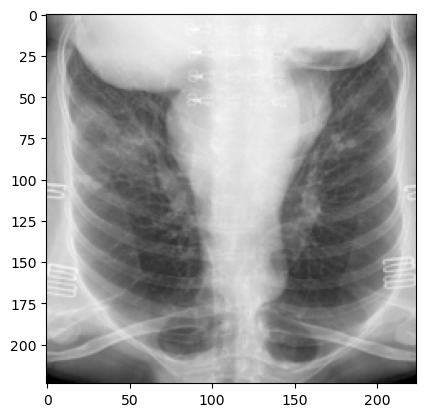

In [23]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=1),  # 为了效果展示，概率设置为1， 通常设置为0.5
    transforms.ToTensor()
])
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape)
    img_tensor = data[0, ...]     # C H W
    img = transform_invert(img_tensor, transforms_func)
    print(img.size)
    plt.imshow(img, cmap="gray")
    plt.show()

#### transforms.CenterCrop

中心剪裁


torch.Size([2, 1, 128, 128])
(128, 128)


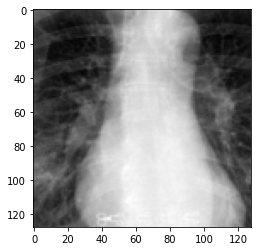

In [ ]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    # 在图像的中心裁剪出128x128的区域，这在数据预处理中常用于缩小图像并保留重要部分
    transforms.CenterCrop(128),
    transforms.ToTensor()
])
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape)
    img_tensor = data[0, ...]     # C H W
    img = transform_invert(img_tensor, transforms_func)
    print(img.size)
    plt.imshow(img, cmap="gray")
    plt.show()

In [ ]:
不在一一展示，可结合官方文档自行学习
ColorJitter
GaussianBlur
RandomPerspective
RandomRotation
RandomAffine
RandomCrop
RandomResizedCrop
RandomInvert
RandomPosterize
RandomSolarize
RandomAdjustSharpness
RandomAutocontrast
RandomEqualize
TrivialAugmentWide

### RandomChoice


可以看到变换后的图片，要么填充 10 个像素，要么垂直翻转，没有即垂直翻转，又填充 10 个像素的。
这就是 randomchoice 的作用，从一系列中选择 1 个。


torch.Size([1, 1, 244, 244])
(244, 244)


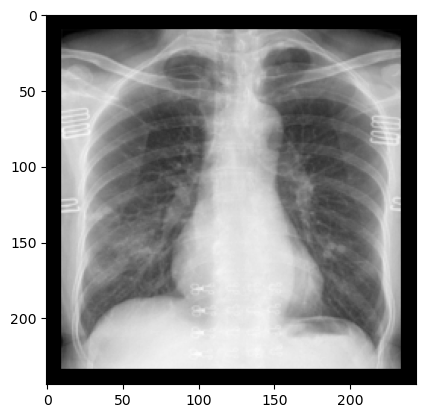

torch.Size([1, 1, 224, 224])
(224, 224)


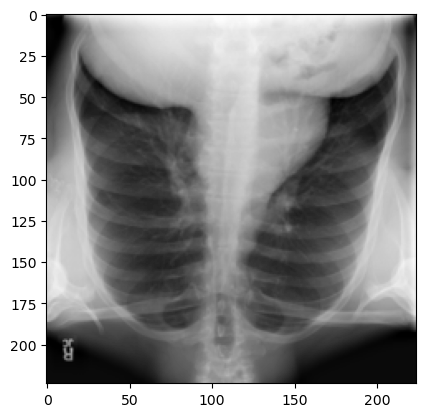

torch.Size([1, 1, 224, 224])
(224, 224)


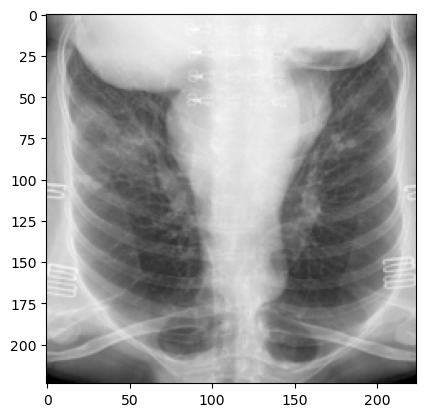

torch.Size([1, 1, 244, 244])
(244, 244)


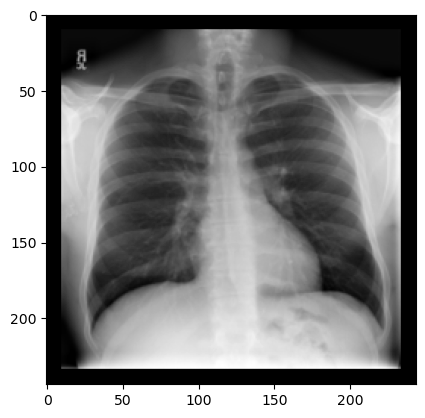

torch.Size([1, 1, 244, 244])
(244, 244)


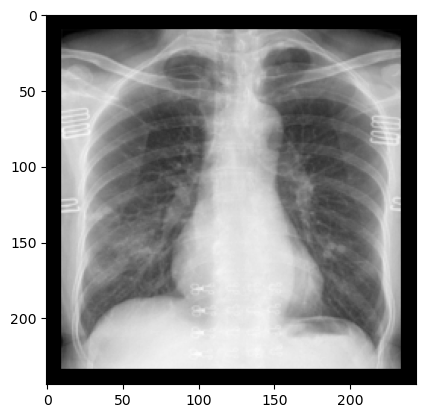

torch.Size([1, 1, 244, 244])
(244, 244)


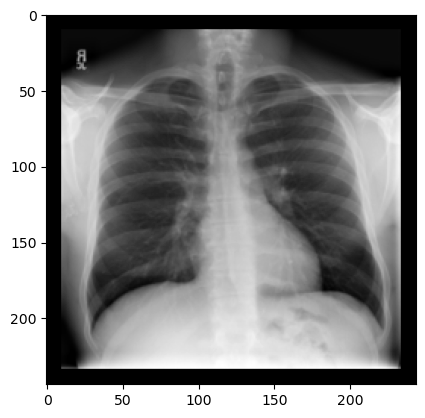

In [29]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomChoice(
        [transforms.Pad(10), transforms.RandomVerticalFlip(p=1)]),
    transforms.ToTensor()
])
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(3):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### RandomOrder


随机排序指的是这一系列变换的顺序会随机打乱。  
通过以下代码可以看到如果是先填充再反转，则填充的黑色像素在图像的底部。  
如果是先反转，再填充，则填充的黑色像素区域在图像的顶部。


torch.Size([1, 1, 324, 224])
(224, 324)


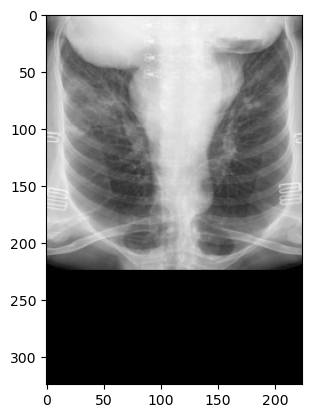

torch.Size([1, 1, 324, 224])
(224, 324)


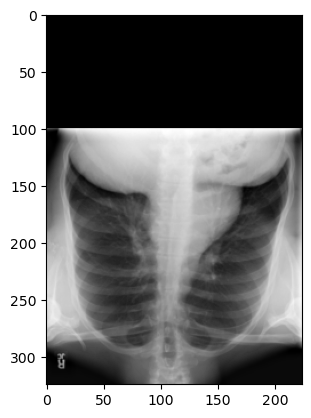

torch.Size([1, 1, 324, 224])
(224, 324)


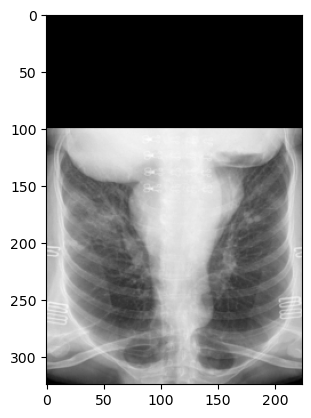

torch.Size([1, 1, 324, 224])
(224, 324)


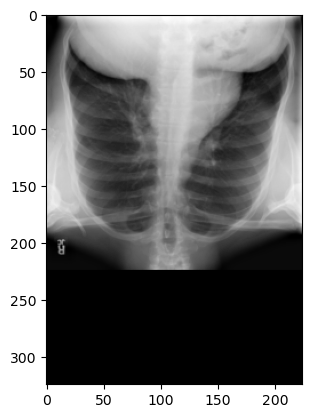

torch.Size([1, 1, 324, 224])
(224, 324)


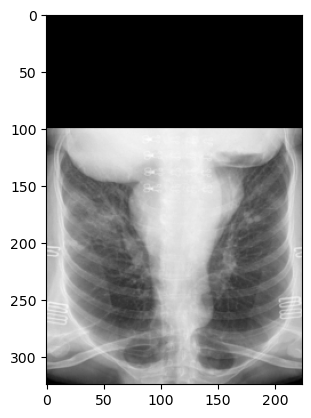

torch.Size([1, 1, 324, 224])
(224, 324)


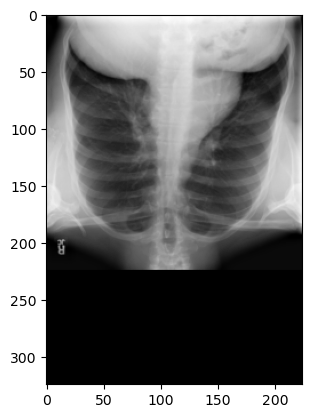

In [ ]:
# transforms.RandomOrder 允许您将多个变换以随机顺序应用。它不会每次都以相同的顺序应用这些变换，从而增加了数据增强的多样性。
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    # # 随机改变Pad和垂直翻转的应用顺序
    transforms.RandomOrder(
        # # 对图像进行填充，右边填充100像素
        # # 随机垂直翻转图像，p=1表示100%概率
        # transforms.Pad((left, top, right, bottom))
        [transforms.Pad((0, 100, 0, 0)), transforms.RandomVerticalFlip(p=1)]),
    transforms.ToTensor()
])
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(3):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### RandomApply


randomapply 与 RandomChoice 的区别仅在于它将一组变换看成一个选择单位，RandomChoice 是一次选一个，RandomApply 是一次选一组（list）.  
可以看到下图中，要么执行缩放 + (填充、反转)，要么只执行缩放。这里的(填充、反转)就是一组变换。


torch.Size([1, 1, 224, 224])
(224, 224)


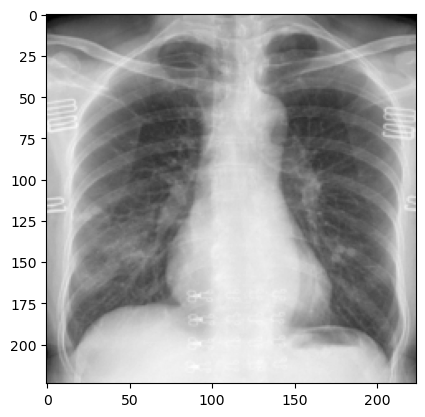

torch.Size([1, 1, 324, 224])
(224, 324)


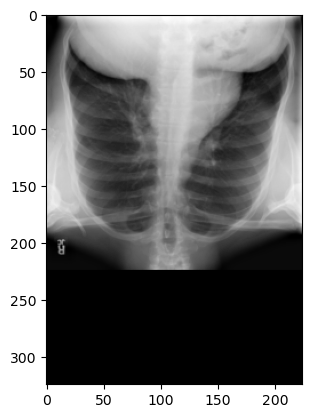

torch.Size([1, 1, 324, 224])
(224, 324)


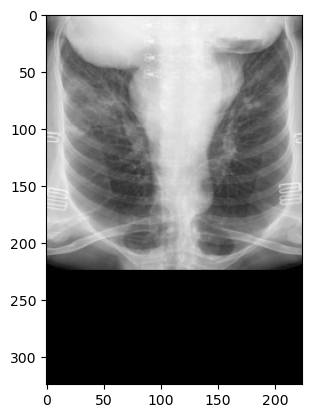

torch.Size([1, 1, 324, 224])
(224, 324)


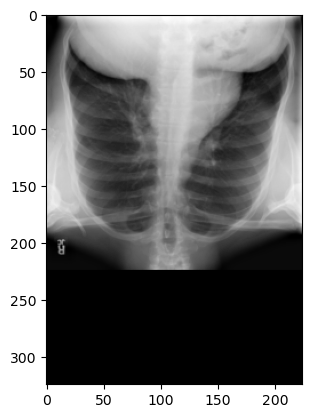

torch.Size([1, 1, 324, 224])
(224, 324)


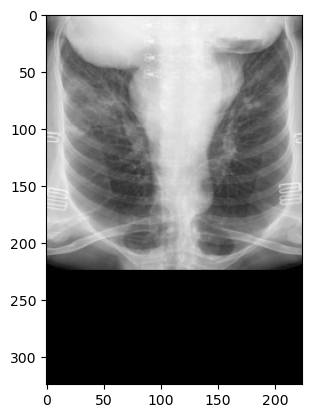

torch.Size([1, 1, 224, 224])
(224, 224)


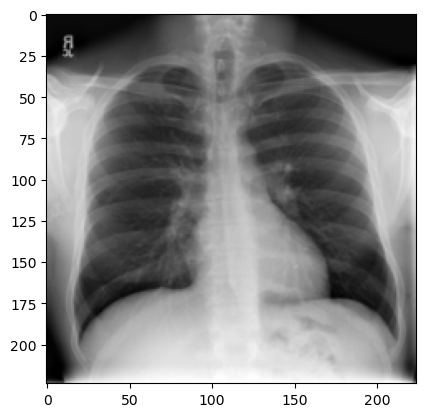

torch.Size([1, 1, 224, 224])
(224, 224)


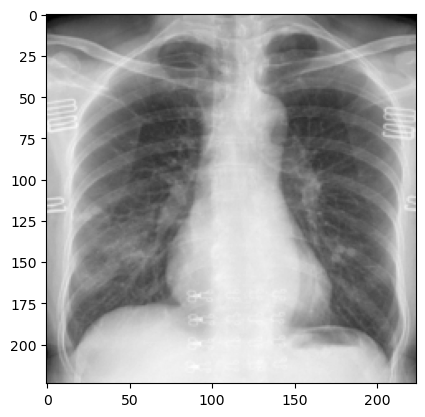

torch.Size([1, 1, 224, 224])
(224, 224)


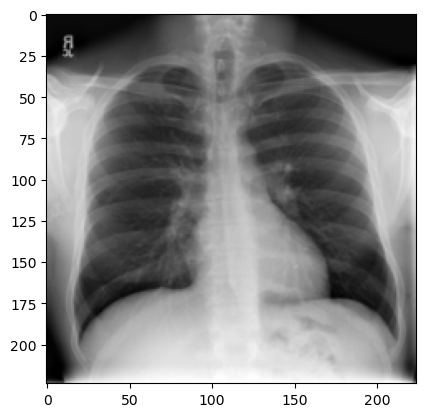

torch.Size([1, 1, 224, 224])
(224, 224)


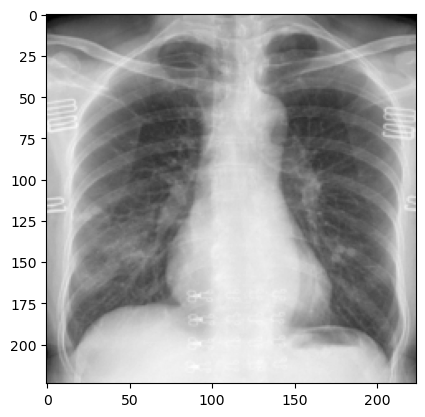

torch.Size([1, 1, 324, 224])
(224, 324)


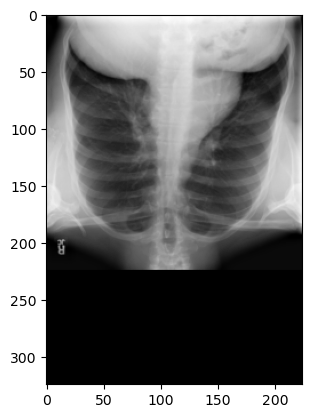

In [ ]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    # 50% 的概率对图像进行 Pad 和 RandomVerticalFlip 的组合操作。
    # 50% 的概率什么都不做，即跳过这些变换。
    transforms.RandomApply(
        [transforms.Pad((0, 100, 0, 0)), transforms.RandomVerticalFlip(p=1)], p=0.5),
    transforms.ToTensor()
])
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(5):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### AutoAugmentPolicy

AutoAugmentPolicy 是 torchvision 库里的一个枚举类，它为图像数据增强提供了预定义的策略。数据增强是一种常见的技术，能够通过对训练图像应用各种随机变换来扩充数据集，从而提升模型的泛化能力。AutoAugment 是一种自动搜索最佳数据增强策略的方法，而 AutoAugmentPolicy 则封装了一些经过验证的有效策略。


torch.Size([1, 1, 4095, 3342])
(3342, 4095)


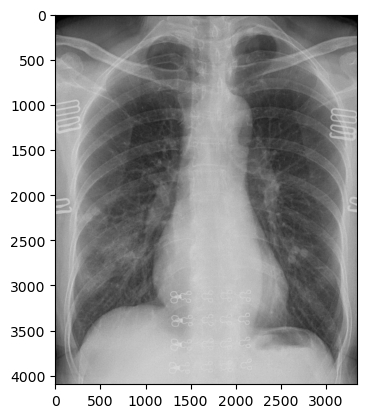

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


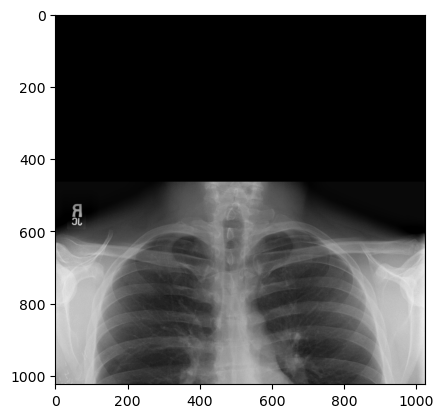

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


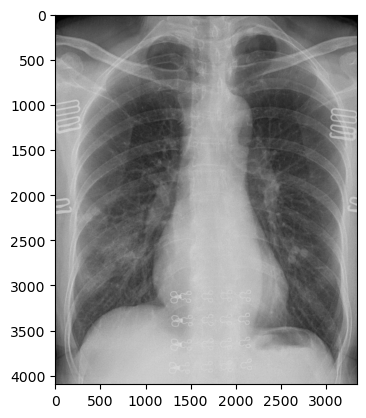

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


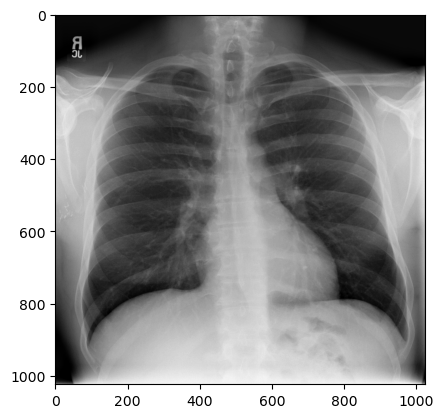

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


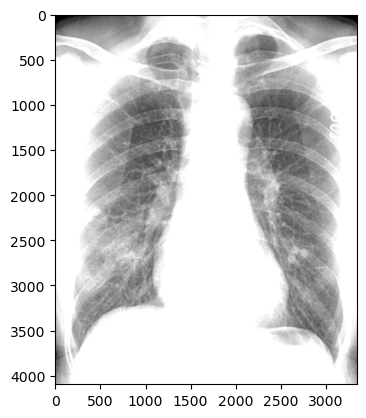

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


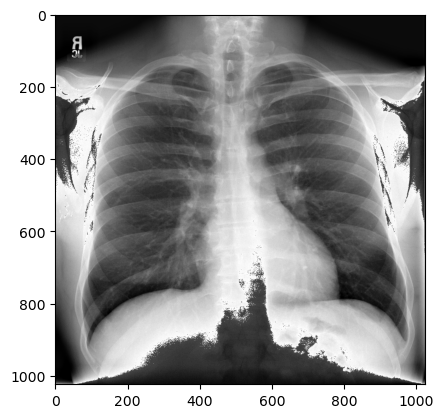

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


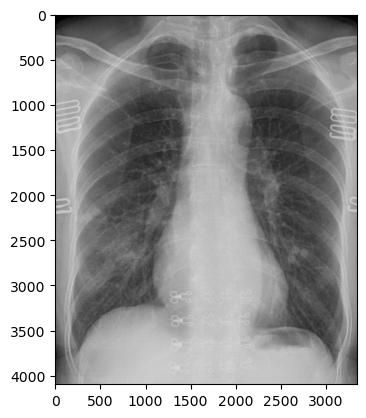

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


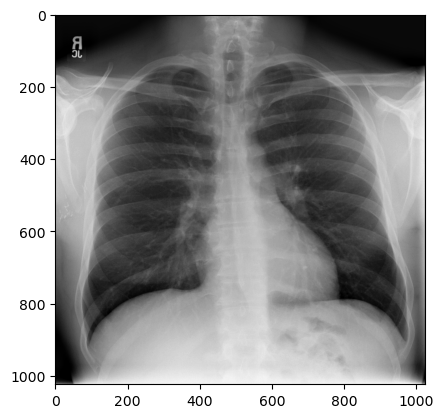

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


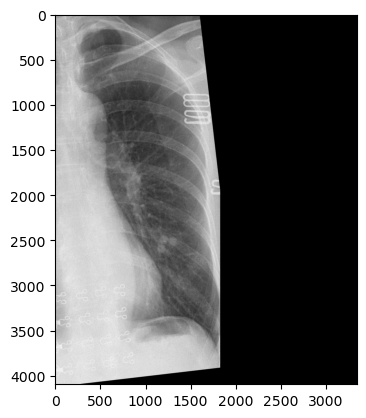

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


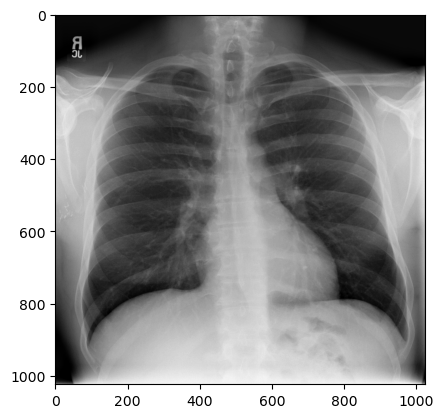

In [41]:
# ransforms.AutoAugmentPolicy.CIFAR10：适用于 CIFAR-10 数据集的增强策略。
# transforms.AutoAugmentPolicy.IMAGENET：适用于 ImageNet 数据集的增强策略。
# transforms.AutoAugmentPolicy.SVHN：适用于 SVHN（Street View House Numbers）数据集的增强策略。
# 这些策略的增强变换可能包括：

# 翻转（Flip）
# 旋转（Rotate）
# 颜色变换（ColorJitter）
# 剪切（Shear）
# 对比度调整（Equalize、Contrast）
# 锐化（Sharpness）
# 仿射变换（Affine）
# Cutout（裁剪）
# Posterize（降低色彩位数）
# Solarize（反转部分颜色）
# Invert（颜色反转）
policy = transforms.AutoAugmentPolicy.CIFAR10
# policy = transforms.AutoAugmentPolicy.IMAGENET
# policy = transforms.AutoAugmentPolicy.SVHN
transforms_func = transforms.Compose([
    transforms.AutoAugment(policy),
    transforms.ToTensor(),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
# transforms_func = transforms.AutoAugment(policy)
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(5):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### RandAugment

通过随机选择若干个图像增强方法（如旋转、剪切、翻转等）来增强数据。
不可逆，即增强后无法完美还原为原图。


torch.Size([1, 1, 4095, 3342])
(3342, 4095)


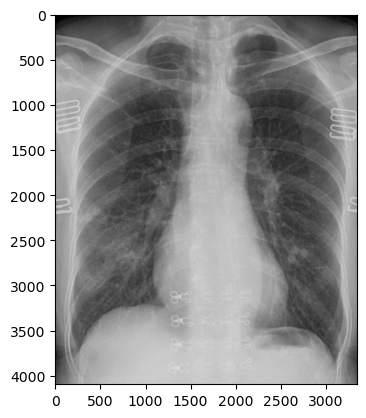

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


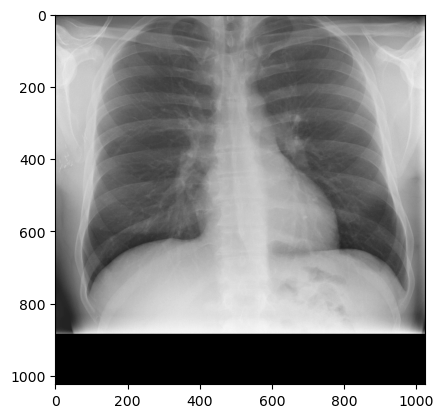

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


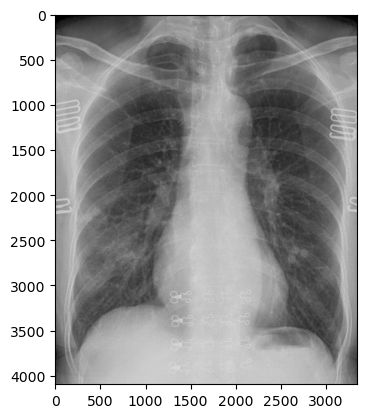

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


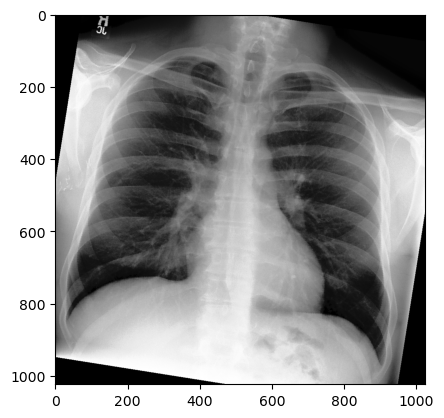

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


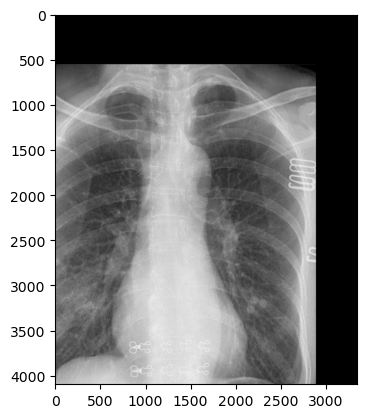

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


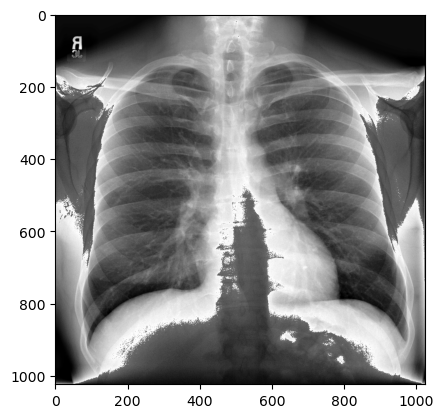

In [42]:

transforms_func = transforms.Compose([
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
# transforms_func = transforms.AutoAugment(policy)
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(3):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### TrivialAugmentWide

TrivialAugmentWide 是 一种比 RandAugment 更简单、但更随机的增强方法，由 2022 年的论文 TrivialAugment: Tuning-Free Yet State-of-the-Art Data Augmentation 提出。

它的核心特点：

随机选择单个增强操作（不像 RandAugment 需要指定 N 个）
增强强度 M 也是随机的（不像 RandAugment 需要手动设定）
完全免调参，适用于各种数据集``


torch.Size([1, 1, 224, 224])
(224, 224)


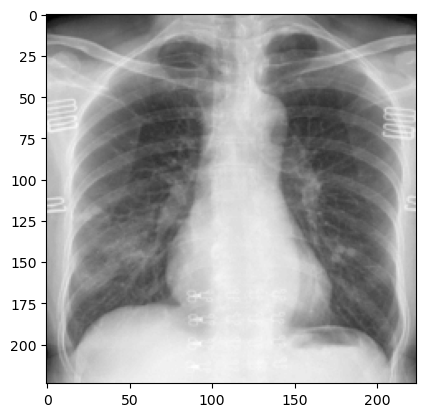

torch.Size([1, 1, 224, 224])
(224, 224)


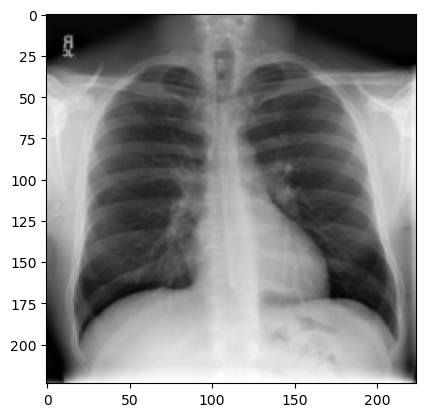

torch.Size([1, 1, 224, 224])
(224, 224)


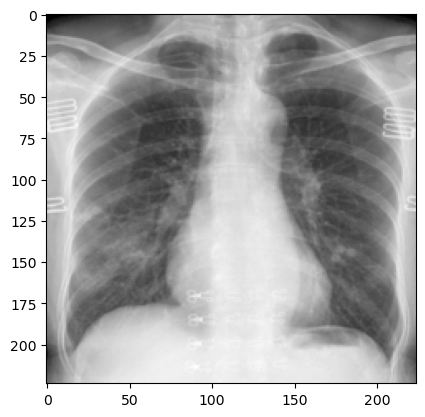

torch.Size([1, 1, 224, 224])
(224, 224)


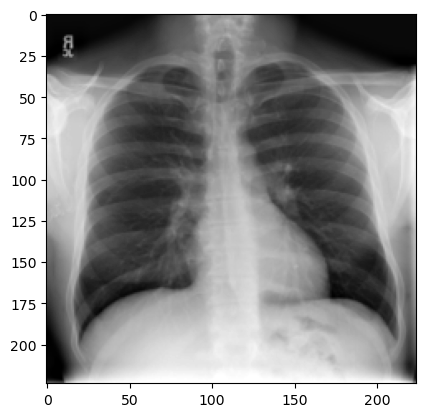

torch.Size([1, 1, 224, 224])
(224, 224)


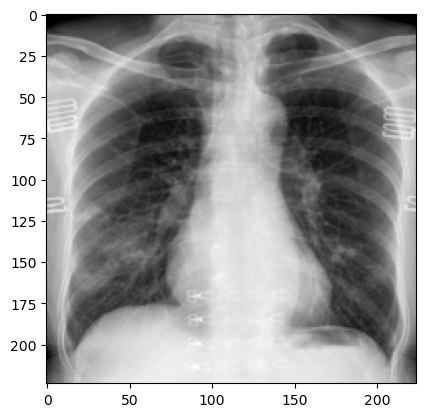

torch.Size([1, 1, 224, 224])
(224, 224)


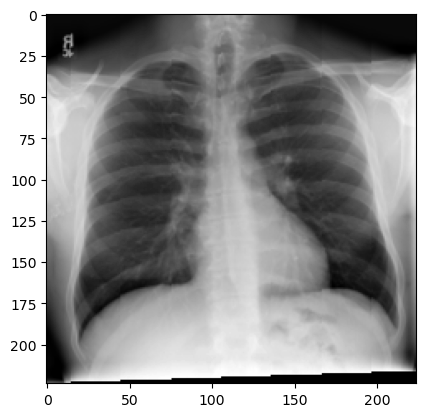

In [43]:

transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
# transforms_func = transforms.AutoAugment(policy)
train_data = COVID19Dataset(
    root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(3):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()